It is a pain to have to keep dumping compute and garbage text files just to regenerate J each time.
The point of this notebook is to carefully review the process of J calculation,
so that we can perform it just once and save to the result to a shared numpy zip file.

In [1]:
%matplotlib notebook
import skyflux

Missing flux value for: GLEAM J202818-254302 at frequency: 204 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 212 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 220 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 227 MHz.
Missing spectral index for: GLEAM J202818-254302


//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pos1_Elm_samples = h5f["pos1_Elm"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.neg1_Elm_samples = h5f["neg1_Elm"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.freq_nodes = h5f["frequencies"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.L_model = h5f["spatial_bandlimit"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:22: H5pyDeprec

delta_nu_in is 1000000.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [3]:
list_az = []
list_alt = []
for source in skyflux.catalog.obj_catalog:
    ra = np.radians(source.ra_angle)
    dec = np.radians(source.dec_angle)
    az, alt = skyflux.rot.eq_to_topo(
        ra, dec,
        lat=np.radians(skyflux.rot.hera_lat),
        lst=np.pi / 3,
        radians=True
    )
    list_az.append(az)
    list_alt.append(alt)

In [4]:
# reformat into arrays so that the spline function can handle the single angles
list_az = np.array(list_az)
list_alt = np.array(list_alt)
print(list_az)
print(list_alt)

[-1.8532937   2.09736031  2.38856675 ...  1.33119085  2.39309436
  1.93842917]
[ 0.88990448  0.35989554 -0.36887102 ...  1.39375765 -0.41546859
  1.2568688 ]


In [5]:
#nside = 16, 32, 64, 128...
nside = 128

# healpix does the interpolation for you?
theta, phi = hp.pix2ang(nside, np.arange(12 * nside * nside))
az = phi
alt = np.pi / 2 - theta
J = skyflux.stokes.format_J(skyflux.stokes.spline_beam_func(150e6, alt, az))
print(theta, phi)

[0.00637889 0.00637889 0.00637889 ... 3.13521376 3.13521376 3.13521376] [0.78539816 2.35619449 3.92699082 ... 2.35619449 3.92699082 5.49778714]


In [6]:
J = skyflux.stokes.format_J(skyflux.stokes.spline_beam_func(150e6, list_alt, list_az))
J.shape

(3872, 2, 2)

In [7]:
empty_blocks = 0
for block in J:
    """
    Make sure that at least one LST works in the day.
    """
    if block[0][0] == 0 and \
        block[1][0] == 0 and \
        block[0][1] == 0 and \
        block[1][1] == 0:
        empty_blocks += 1
empty_blocks

1538

In [8]:
""" This is a major problem, is it not? """
percent_empty = 100 * empty_blocks / len(J)
percent_empty

39.72107438016529

In [9]:
# Hard-coding a right-ascension,
# this should be a maximum response...

# these are the maxima as they appear in the catalog,
# i.e. NOT the theoretical maxima
ra_max = np.radians(59.984791666666666)
dec_max = np.radians(-23.4345)

# J matrices are now automatically formatted
J_max = skyflux.stokes.J_matrix(ra_max, dec_max, lst=np.pi/3)
print("xx:", J_max[0][0][0])
print("yy:", J_max[0][1][1])
J_max.shape

xx: (0.31718473517814755-0.24593409765985316j)
yy: (0.3904975309365466-0.30367048435532645j)


(1, 2, 2)

<IPython.core.display.Javascript object>


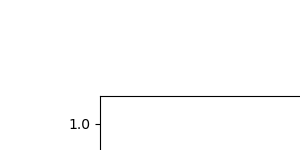

In [10]:
dec_decf = np.radians(-30.72)

ra_decf = 0

first_term = []

while ra_decf <= 120:
    J_decf = skyflux.stokes.J_matrix(
        np.radians(ra_decf), dec_decf, lst=np.pi / 3
    )
    #print("\nDeclination (degrees):", np.around(np.degrees(dec_decf), 2),
    #    "\nRight acension (degrees):", np.around(ra_decf, 2),
    #    "\nResultant J matrix:\n", J_decf, "\n")
    first_term.append(J_decf[0][0][0])
    ra_decf += 10

im = np.imag(np.array(first_term))
re = np.real(np.array(first_term))
ab = np.abs(np.array(first_term))
plt.plot(im, label="imaginary")
plt.plot(re, label="real")
plt.plot(ab, label="abs")
plt.title("xx over ra")
plt.legend()
plt.show()

In [ ]:
plt.clf()
ra_decf = 0

first_term = []

while ra_decf <= 120:
    J_decf = skyflux.stokes.J_matrix(
        np.radians(ra_decf), dec_decf, lst=np.pi / 3
    )
    #print("\nDeclination (degrees):", np.around(np.degrees(dec_decf), 2),
    #    "\nRight acension (degrees):", np.around(ra_decf, 2),
    #    "\nResultant J matrix:\n", J_decf, "\n")
    first_term.append(J_decf[0][1][1])
    ra_decf += 10
im = np.imag(np.array(first_term))
re = np.real(np.array(first_term))
ab = np.abs(np.array(first_term))
plt.plot(im, label="imaginary")
plt.plot(re, label="real")
plt.plot(ab, label="abs")
plt.title("yy over ra")
plt.legend()
plt.show()

In [ ]:
ra_raf = np.radians(59.984791666666666)

dec_raf = -40.72

first_term = []

while dec_raf <= -20.72:
    J_raf = skyflux.stokes.J_matrix(
        ra_raf, np.radians(dec_raf), lst=np.pi / 3
    )
    first_term.append(J_raf[0][0][0])
    dec_raf += 5
im = np.imag(np.array(first_term))
re = np.real(np.array(first_term))
ab = np.abs(np.array(first_term))
plt.plot(im, label="imaginary")
plt.plot(re, label="real")
plt.plot(ab, label="abs")
plt.legend()
plt.title("xx over dec")
plt.show()

In [ ]:
dec_raf = -40.72

first_term = []

while dec_raf <= -20.72:
    J_raf = skyflux.stokes.J_matrix(
        ra_raf, np.radians(dec_raf), lst=np.pi / 3
    )
    first_term.append(J_raf[0][0][0])
    dec_raf += 5
im = np.imag(np.array(first_term))
re = np.real(np.array(first_term))
ab = np.abs(np.array(first_term))
plt.plot(im, label="imaginary")
plt.plot(re, label="real")
plt.plot(ab, label="abs")
plt.legend()
plt.title("xx over dec")
plt.show()